## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [3]:
import pandas as pd

file_path_train = 'C:/Users/kaczm/Downloads/archive/train.csv'
file_path_test = 'C:/Users/kaczm/Downloads/archive/test.csv'

try:
    training_data = pd.read_csv(file_path_train, encoding='utf-8')
    testing_data = pd.read_csv(file_path_test, encoding='utf-8')
except UnicodeDecodeError:
    try:
        training_data = pd.read_csv(file_path_train, encoding='latin1')
        testing_data = pd.read_csv(file_path_test, encoding='latin1')
    except Exception as e:
        print(f"An error occurred: {str(e)}")



In [4]:
datafr = pd.concat([training_data, testing_data], ignore_index=True)
cols = ['text','sentiment']
datafr = datafr[cols]

In [5]:
pd.set_option('max_colwidth', None)
datafr.head(10)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative
5,http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth,neutral
6,2am feedings for the baby are fun when he is all smiles and coos,positive
7,Soooo high,neutral
8,Both of you,neutral
9,Journey!? Wow... u just became cooler. hehe... (is that possible!?),positive


In [6]:
print(datafr.isna().sum())
print(datafr.size)

# remove nas

datafr.dropna(inplace = True)

text         1282
sentiment    1281
dtype: int64
64592


sentiment
neutral     12547
positive     9685
negative     8782
Name: count, dtype: int64


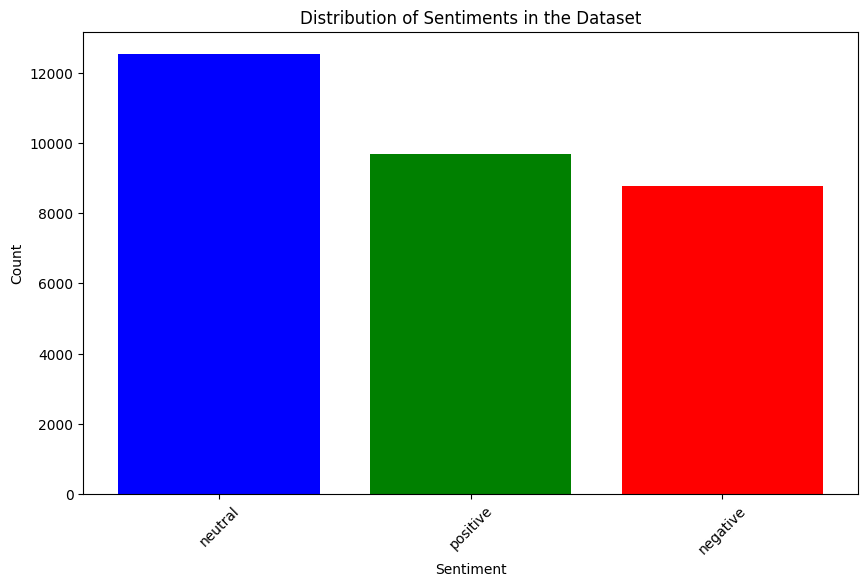

In [7]:
print(datafr['sentiment'].value_counts())

# let's plot it

import matplotlib.pyplot as plt 

# Get value counts
sentiment_counts = datafr['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6))  
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['blue', 'green', 'red']) 
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in the Dataset')
plt.xticks(rotation=45)  


plt.show()

In [10]:
# now we need to tokenize and clean the data

import re

texts = datafr['text']

matcher = re.compile(r"[\w]+|[*]+|[,.?!;:]")

def remove_urls(text):

    html_matcher = re.compile(r'http?\S+|www\.\S+')

    return html_matcher.sub(r'', text)

def remove_abbreviatons(text):

    abbr_matcher = re.compile(r"\w+'\w+")
    
    return abbr_matcher.sub(r'', text)

def custom_tokenizer(text):

    return matcher.findall(text)


In [25]:
# now we need to tokenize and clean the data

import spacy
from spacy.lang.en import English

nlp = spacy.load('en_core_web_md')

def tokenize_dataset(txts):
    
    tokenized_texts = []

    for doc_text in txts:

        clean_text = remove_urls(doc_text)
        clean_text = remove_abbreviatons(clean_text)

        tokens = [
            token.lower()  # Lowercase each token
            for token in custom_tokenizer(clean_text)
            if not nlp.vocab[token].is_stop  # Remove stop words
            and (token.isalpha() or token == "****") 
            and len(token) > 2 # Remove non-alphabetical tokens (punctuation and numbers)
        ]
        tokenized_texts.append(tokens)

    return tokenized_texts


RegistryError: [E892] Unknown function registry: 'vectors'.

Available names: architectures, augmenters, batchers, callbacks, cli, datasets, displacy_colors, factories, initializers, languages, layers, lemmatizers, loggers, lookups, losses, misc, models, ops, optimizers, readers, schedules, scorers, tokenizers

In [29]:
import spacy
print(spacy.__version__)

4.0.0.dev1


In [28]:
tokenized_texts = tokenize_dataset(texts)

NameError: name 'tokenize_dataset' is not defined

In [ ]:
tokenized_texts[:5]

[['responded', 'going'],
 ['sooo', 'sad', 'miss', 'san', 'diego'],
 ['boss', 'bullying'],
 ['interview', 'leave'],
 ['sons', '****', 'couldn', 'releases', 'bought']]

In [ ]:
# now let's lemmatize text

'''!python -m spacy download en_core_web_md'''


def lemmatize_text(txts):
    
    lemmatized_texts = []

    for doc in txts:

        lemmatized_tokens = [token.lemma_ 
                             for token in nlp(" ".join(doc))]
        
        lemmatized_texts.append(lemmatized_tokens)
        
    return lemmatized_texts




In [18]:
lemmatized_texts = lemmatize_text(tokenized_texts)

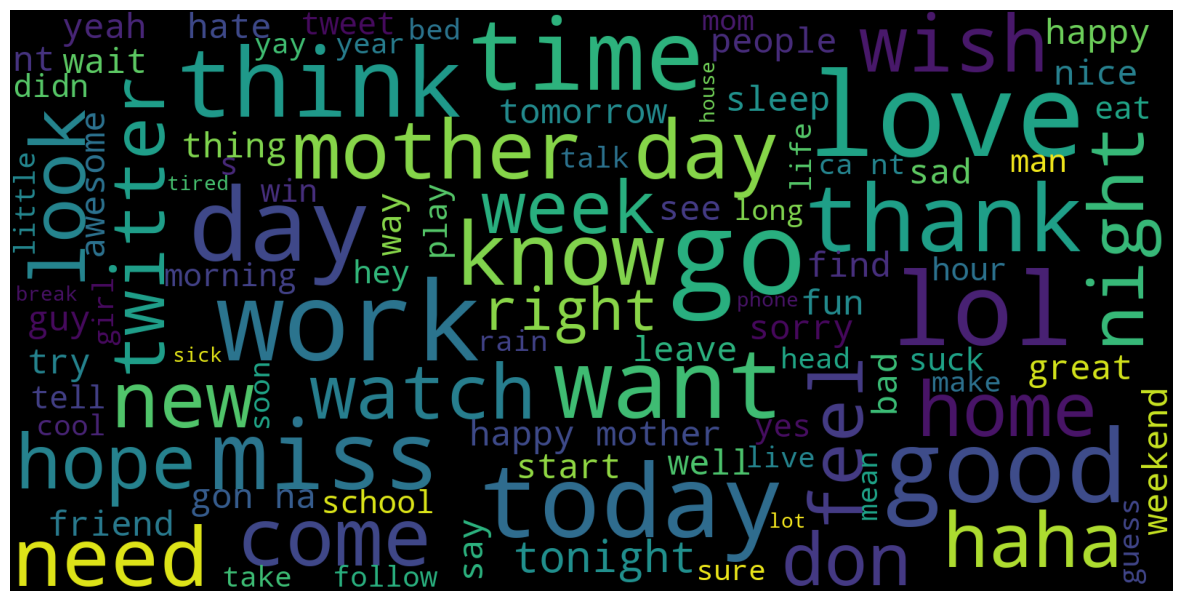

In [ ]:


from wordcloud import WordCloud
from wordcloud import STOPWORDS

def generate_wordcloud(data, title=None):
    # Define stopwords
    
    # Generate the word cloud
    wordcloud = WordCloud(
        max_words=100,
        max_font_size=40,
        scale=4
    ).generate(" ".join([" ".join(doc) for doc in data]))
    
    # Plot the word cloud
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


generate_wordcloud(lemmatized_texts)

In [14]:
# next let's turn sentiment into numerical values

def adjust_values(df):

    mapping = {'neutral': 0, 'negative': 1, 'positive': 2}
    df['sentiment'] = df['sentiment'].replace(mapping)
    return df 

adjust_values(datafr)

,text,sentiment
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,1
2,my boss is bullying me...,1
3,what interview! leave me alone,1
4,"Sons of ****, why couldn`t they put them on the releases we already bought",1
...,...,...
31010,"its at 3 am, im very tired but i can`t sleep but i try it",1
31011,"All alone in this old house again. Thanks for the net which keeps me alive and kicking! Whoever invented the net, i wanna kiss your hair!",2
31012,I know what you mean. My little dog is sinking into depression... he wants to move someplace tropical,1
31013,_sutra what is your next youtube video gonna be about? I love your videos!,2


In [15]:
sentiments = datafr['sentiment'].values

from collections import Counter
from itertools import chain


def build_vocab(texts, min_count=3):
    word_counts = Counter(chain.from_iterable(texts))
    
    # Filter words by count and reassign indices
    vocab = {
        word: idx + 1 
        for idx, (word, count) 
        in enumerate((w, c) for w, c in word_counts.items() if c >= min_count)
    }
    
    return vocab

def texts_to_sequences(texts, vocab):
    
 
    return [[vocab[word] for word in doc if word in vocab] for doc in texts]

vocab = build_vocab(lemmatized_texts, min_count=3)
max_features = len(vocab)

sequences = texts_to_sequences(lemmatized_texts, vocab)

NameError: name 'lemmatized_texts' is not defined

In [21]:
sequences = texts_to_sequences(lemmatized_texts, vocab)

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max(len(seq) for seq in sequences)

In [23]:
# let's divide into train and test sets

from sklearn.model_selection import train_test_split
import numpy as np  # Ensure NumPy is imported

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure all sequences have the same length
sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Convert to NumPy array
sequences_array = np.array(sequences_padded)

# Ensure sentiments is a NumPy array
sentiments_array = np.array(sentiments)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(sequences_array, sentiments_array, test_size=0.33, random_state=42)


In [18]:
# now define a callback class
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.95:
            print('\n Stopped Training!\n')
            self.model.stop_training = True

# let's define a function for model training 

def train_model(model, model_name, n_epochs, batch_size, X_data, y_data, validation_split):    
    checkpoint_path = model_name+"_cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,  save_weights_only=True, verbose=1)
    callbacks = myCallback()
    history = model.fit(
        X_data,
        y_data,
        steps_per_epoch=batch_size,
        epochs=n_epochs,
        validation_split=validation_split,
        verbose=1,
        callbacks=[cp_callback]
    )
    return history



In [19]:
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [20]:
# let's define a function to draw us a graph after every epoch

def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [21]:
# another function for F1 score

from sklearn.metrics import f1_score, classification_report

def calculate_f1(y_true, y_pred, average_mode='weighted'):
    
    f1 = f1_score(y_true, y_pred, average=average_mode)
    print(f"F1 Score ({average_mode} average): {f1:.2f}")
    
    # Detailed classification report
    print("Detailed classification report:")
    print(classification_report(y_true, y_pred, target_names=["neutral", "negative", "positive"]))



In [22]:
import os  

class Model_A():
    def __new__(self):
        inp = Input(shape=(max_length, ))
        embed_size = 128
        x = Embedding(max_features + 1, embed_size)(inp)
        x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
        x = GlobalMaxPool1D()(x)
        x = Dropout(0.1)(x)
        x = Dense(50, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(3, activation="softmax")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

        
        return model
model_a = Model_A()
history_a = train_model(model_a, "model_a", 10, 64, X_train, y_train, 0.2)
model_a_score = calculate_f1(y_test, np.argmax(model_a.predict(X_test), axis=1))


Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 1.0945 - accuracy: 0.3943
Epoch 1: saving model to model_a_cp-0001.ckpt
64/64 [==============================] - 7s 78ms/step - loss: 1.0945 - accuracy: 0.3943 - val_loss: 1.0915 - val_accuracy: 0.3985
Epoch 2/10
63/64 [============================>.] - ETA: 0s - loss: 1.0897 - accuracy: 0.4036
Epoch 2: saving model to model_a_cp-0002.ckpt
64/64 [==============================] - 3s 46ms/step - loss: 1.0898 - accuracy: 0.4030 - val_loss: 1.0888 - val_accuracy: 0.3985
Epoch 3/10
63/64 [============================>.] - ETA: 0s - loss: 1.0882 - accuracy: 0.4026
Epoch 3: saving model to model_a_cp-0003.ckpt
64/64 [==============================] - 2s 35ms/step - loss: 1.0880 - accuracy: 0.4030 - val_loss: 1.0878 - val_accuracy: 0.3985
Epoch 4/10
63/64 [============================>.] - ETA: 0s - loss: 1.0875 - accuracy: 0.4032
Epoch 4: saving model to model_a_cp-0004.ckpt
64/64 [==============================] - 2s 35ms/s

c:\Users\kaczm\.virtualenvs\ZUM_project-8lBn28jB\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kaczm\.virtualenvs\ZUM_project-8lBn28jB\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kaczm\.virtualenvs\ZUM_project-8lBn28jB\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

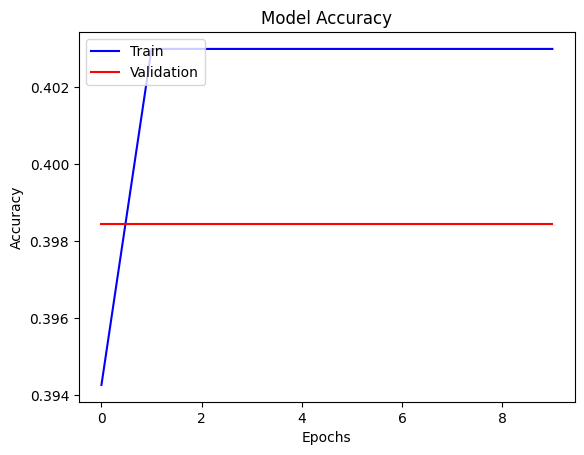

In [23]:
generate_graph(history_a)

In [24]:
class Model_B():
    def __new__(self):
        inp = Input(shape=(max_length, ))
        embed_size = 128
        x = Embedding(max_features + 1, embed_size)(inp)
        x = SpatialDropout1D(0.25)(x)
        x = LSTM(100, return_sequences=True, name='lstm_layer')(x)
        x = GlobalMaxPool1D()(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation="relu")(x)
        x = Dropout(0.5)(x)
        x = Dense(3, activation="softmax")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        
        return model

model_b = Model_B()
history_b = train_model(model_b, "model_b", 15, 64, X_train, y_train, 0.2)
model_b_score = calculate_f1(y_test, np.argmax(model_b.predict(X_test), axis=1))


Epoch 1/15
64/64 [==============================] - ETA: 0s - loss: 1.0785 - accuracy: 0.4182
Epoch 1: saving model to model_b_cp-0001.ckpt
64/64 [==============================] - 8s 97ms/step - loss: 1.0785 - accuracy: 0.4182 - val_loss: 1.0033 - val_accuracy: 0.5407
Epoch 2/15
64/64 [==============================] - ETA: 0s - loss: 0.8361 - accuracy: 0.6392
Epoch 2: saving model to model_b_cp-0002.ckpt
64/64 [==============================] - 5s 79ms/step - loss: 0.8361 - accuracy: 0.6392 - val_loss: 0.7255 - val_accuracy: 0.7069
Epoch 3/15
64/64 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7421
Epoch 3: saving model to model_b_cp-0003.ckpt
64/64 [==============================] - 5s 79ms/step - loss: 0.6724 - accuracy: 0.7421 - val_loss: 0.7085 - val_accuracy: 0.7096
Epoch 4/15
64/64 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.7775
Epoch 4: saving model to model_b_cp-0004.ckpt
64/64 [==============================] - 5s 80ms/s

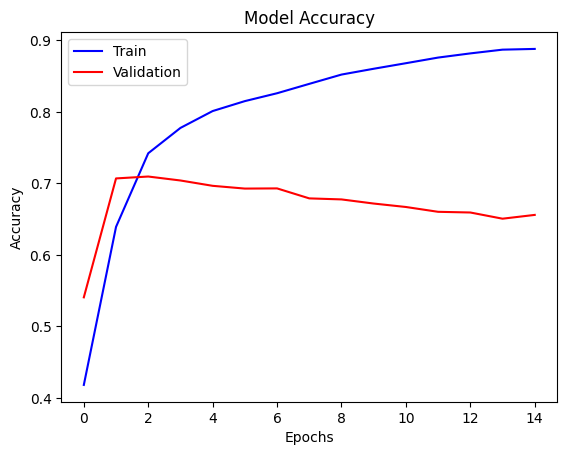

In [25]:
generate_graph(history_b)

In [26]:
class Model_C():
    def __new__(self):
        inp = Input(shape=(max_length, ))
        embed_size = 128
        model = Sequential()
        model.add(Embedding(max_features +1 , embed_size))
        model.add(Bidirectional(LSTM(75, return_sequences = True)))
        model.add(GlobalMaxPool1D())
        model.add(Dense(16, activation="relu"))
        model.add(Dropout(0.03))
        model.add(Dense(8, activation="relu"))
        model.add(Dropout(0.1))
        model.add( Dense(3, activation="softmax"))
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        
        return model

model_c = Model_C()
history_c = train_model(model_c, "model_c", 15, 32, X_train, y_train, 0.2)
model_c_score = calculate_f1(y_test, np.argmax(model_c.predict(X_test), axis=1))


Epoch 1/15
32/32 [==============================] - ETA: 0s - loss: 1.0838 - accuracy: 0.4055
Epoch 1: saving model to model_c_cp-0001.ckpt
32/32 [==============================] - 10s 188ms/step - loss: 1.0838 - accuracy: 0.4055 - val_loss: 1.0518 - val_accuracy: 0.4697
Epoch 2/15
32/32 [==============================] - ETA: 0s - loss: 0.9670 - accuracy: 0.5270
Epoch 2: saving model to model_c_cp-0002.ckpt
32/32 [==============================] - 5s 153ms/step - loss: 0.9670 - accuracy: 0.5270 - val_loss: 0.8670 - val_accuracy: 0.6196
Epoch 3/15
32/32 [==============================] - ETA: 0s - loss: 0.7559 - accuracy: 0.6676
Epoch 3: saving model to model_c_cp-0003.ckpt
32/32 [==============================] - 5s 156ms/step - loss: 0.7559 - accuracy: 0.6676 - val_loss: 0.7352 - val_accuracy: 0.6927
Epoch 4/15
32/32 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.7526
Epoch 4: saving model to model_c_cp-0004.ckpt
32/32 [==============================] - 5s 16

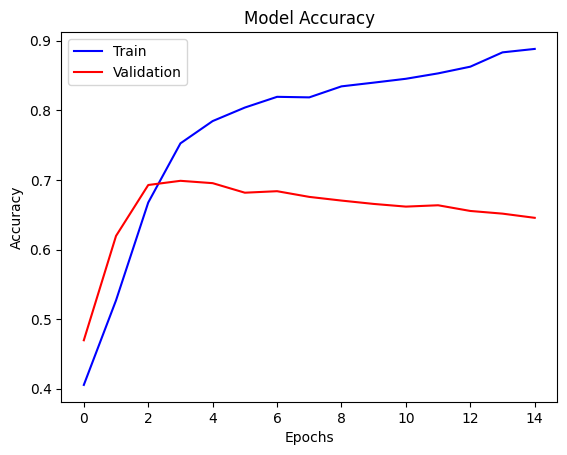

In [27]:
generate_graph(history_c)

In [28]:
# let's now start working with CNN
# I will do tokenization and vocab building again to see if maybe my techniques haven't skewed the data


X_train, X_test, y_train, y_test = train_test_split(texts, sentiments, test_size = 0.25, random_state = 42)

vocab_size = 10000 
max_length = 50

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def tokenize_texts(txts, vocab_size, max_length):
    
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    
    tokenizer.fit_on_texts(txts)
    
    sequences = tokenizer.texts_to_sequences(txts)
    
    # pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")
    
    return padded_sequences, tokenizer

X_train_tokenized, tokenizer = tokenize_texts(X_train, vocab_size, max_length)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_test_tokenized = pad_sequences(X_test_tokenized, maxlen=max_length, padding="post", truncating="post")



In [29]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

class Model_CNN_A():
    
    def __init__(self, vocab_size, max_length):
        self.embedding_dim = 128  
        self.model = self.build_model(vocab_size, max_length)

    def build_model(self, vocab_size, max_length):
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=max_length),
            Conv1D(filters=128, kernel_size=5, activation='relu'),
            MaxPooling1D(pool_size=4),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')  # 3 classes: neutral, negative, positive
        ])
        return model

model_cnn_a = Model_CNN_A(vocab_size, max_length)

model_cnn_a.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn_1 = model_cnn_a.model.fit(X_train_tokenized, y_train, epochs=10, batch_size=32, validation_data=(X_test_tokenized, y_test))

# Evaluate
loss, accuracy = model_cnn_a.model.evaluate(X_test_tokenized, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
727/727 [==============================] - 9s 12ms/step - loss: 0.7957 - accuracy: 0.6337 - val_loss: 0.6635 - val_accuracy: 0.7167
Epoch 2/10
727/727 [==============================] - 8s 11ms/step - loss: 0.5381 - accuracy: 0.7849 - val_loss: 0.6571 - val_accuracy: 0.7230
Epoch 3/10
727/727 [==============================] - 8s 11ms/step - loss: 0.3541 - accuracy: 0.8680 - val_loss: 0.7456 - val_accuracy: 0.7076
Epoch 4/10
727/727 [==============================] - 8s 11ms/step - loss: 0.1883 - accuracy: 0.9344 - val_loss: 0.9776 - val_accuracy: 0.6955
Epoch 5/10
727/727 [==============================] - 8s 11ms/step - loss: 0.0870 - accuracy: 0.9729 - val_loss: 1.2130 - val_accuracy: 0.6861
Epoch 6/10
727/727 [==============================] - 8s 11ms/step - loss: 0.0471 - accuracy: 0.9864 - val_loss: 1.5176 - val_accuracy: 0.6757
Epoch 7/10
727/727 [==============================] - 8s 11ms/step - loss: 0.0321 - accuracy: 0.9918 - val_loss: 1.6662 - val_accuracy: 0.6840

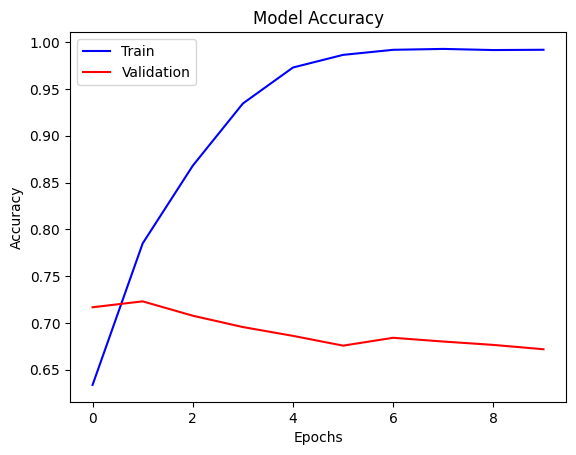

In [30]:
generate_graph(history_cnn_1)

In [31]:
y_pred = model_cnn_a.model.predict(X_test_tokenized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate and print F1 score and classification report
calculate_f1(y_test, y_pred_classes, average_mode='weighted')

243/243 [==============================] - 0s 2ms/step
F1 Score (weighted average): 0.67
Detailed classification report:
              precision    recall  f1-score   support

     neutral       0.62      0.70      0.66      3151
    negative       0.65      0.66      0.65      2162
    positive       0.79      0.65      0.71      2441

    accuracy                           0.67      7754
   macro avg       0.69      0.67      0.67      7754
weighted avg       0.68      0.67      0.67      7754



In [32]:
class Model_CNN_B():
    
    def __init__(self, vocab_size, max_length):
        self.embedding_dim = 128  
        self.model = self.build_model(vocab_size, max_length)

    def build_model(self, vocab_size, max_length):
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=max_length),
            Dropout(0.5),
            Conv1D(filters=128, kernel_size=5, activation='relu'),
            MaxPooling1D(pool_size=4),
            Conv1D(filters=64, kernel_size=4, activation='relu'),
            MaxPooling1D(pool_size=4),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')  # 3 classes: neutral, negative, positive
        ])


        return model

model_cnn_b = Model_CNN_B(vocab_size, max_length)

model_cnn_b.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn_2 = model_cnn_b.model.fit(X_train_tokenized, y_train, epochs=10, batch_size=32, validation_data=(X_test_tokenized, y_test))

# Evaluate
loss, accuracy = model_cnn_b.model.evaluate(X_test_tokenized, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
727/727 [==============================] - 12s 15ms/step - loss: 0.8583 - accuracy: 0.5870 - val_loss: 0.6652 - val_accuracy: 0.7248
Epoch 2/10
727/727 [==============================] - 8s 12ms/step - loss: 0.6057 - accuracy: 0.7524 - val_loss: 0.6420 - val_accuracy: 0.7399
Epoch 3/10
727/727 [==============================] - 9s 12ms/step - loss: 0.4989 - accuracy: 0.8032 - val_loss: 0.6546 - val_accuracy: 0.7303
Epoch 4/10
727/727 [==============================] - 8s 12ms/step - loss: 0.4092 - accuracy: 0.8464 - val_loss: 0.6843 - val_accuracy: 0.7257
Epoch 5/10
727/727 [==============================] - 12s 16ms/step - loss: 0.3405 - accuracy: 0.8732 - val_loss: 0.7576 - val_accuracy: 0.7121
Epoch 6/10
727/727 [==============================] - 14s 20ms/step - loss: 0.2804 - accuracy: 0.8965 - val_loss: 0.8169 - val_accuracy: 0.7118
Epoch 7/10
727/727 [==============================] - 14s 19ms/step - loss: 0.2344 - accuracy: 0.9151 - val_loss: 0.9191 - val_accuracy: 0.

In [33]:
y_pred = model_cnn_b.model.predict(X_test_tokenized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate and print F1 score and classification report
calculate_f1(y_test, y_pred_classes, average_mode='weighted')

243/243 [==============================] - 0s 2ms/step
F1 Score (weighted average): 0.70
Detailed classification report:
              precision    recall  f1-score   support

     neutral       0.67      0.66      0.66      3151
    negative       0.67      0.68      0.68      2162
    positive       0.76      0.77      0.77      2441

    accuracy                           0.70      7754
   macro avg       0.70      0.70      0.70      7754
weighted avg       0.70      0.70      0.70      7754



In [34]:
# now let's also try balancing the classes and adding batch normalization

from sklearn.utils.class_weight import compute_class_weight
from keras.layers import BatchNormalization
from keras.optimizers import Adam

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1, 2], y=sentiments)

# Convert class weights to a dictionary for use in training
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}

adam = Adam(learning_rate = 0.0005)

class Model_CNN_C():
    
    def __init__(self, vocab_size, max_length):
        self.embedding_dim = 128  
        self.model = self.build_model(vocab_size, max_length)

    def build_model(self, vocab_size, max_length):
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=max_length),
            Dropout(0.6),
            Conv1D(filters=128, kernel_size=5, activation='relu'),
            BatchNormalization(),  # batch normalization after Conv layer
            MaxPooling1D(pool_size=4),
            Conv1D(filters=64, kernel_size=4, activation='relu'),
            MaxPooling1D(pool_size=4),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')  
        ])

        return model

model_cnn_c = Model_CNN_C(vocab_size, max_length)

model_cnn_c.model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn_3 = model_cnn_c.model.fit(X_train_tokenized, y_train, epochs=10, batch_size=32, validation_data=(X_test_tokenized, y_test), class_weight=class_weight_dict)

# Evaluate
loss, accuracy = model_cnn_c.model.evaluate(X_test_tokenized, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")



Epoch 1/10
727/727 [==============================] - 10s 13ms/step - loss: 1.0086 - accuracy: 0.4563 - val_loss: 0.8511 - val_accuracy: 0.5665
Epoch 2/10
727/727 [==============================] - 9s 13ms/step - loss: 0.7218 - accuracy: 0.6791 - val_loss: 0.7449 - val_accuracy: 0.6729
Epoch 3/10
727/727 [==============================] - 9s 13ms/step - loss: 0.6123 - accuracy: 0.7398 - val_loss: 0.7037 - val_accuracy: 0.6996
Epoch 4/10
727/727 [==============================] - 9s 12ms/step - loss: 0.5391 - accuracy: 0.7760 - val_loss: 0.6817 - val_accuracy: 0.7163
Epoch 5/10
727/727 [==============================] - 9s 12ms/step - loss: 0.4783 - accuracy: 0.8048 - val_loss: 0.7033 - val_accuracy: 0.7053
Epoch 6/10
727/727 [==============================] - 9s 12ms/step - loss: 0.4286 - accuracy: 0.8291 - val_loss: 0.6742 - val_accuracy: 0.7297
Epoch 7/10
727/727 [==============================] - 9s 12ms/step - loss: 0.3851 - accuracy: 0.8466 - val_loss: 0.7231 - val_accuracy: 0.714

In [35]:
y_pred = model_cnn_c.model.predict(X_test_tokenized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate and print F1 score and classification report
calculate_f1(y_test, y_pred_classes, average_mode='weighted')

  1/243 [..............................] - ETA: 11s

243/243 [==============================] - 1s 2ms/step
F1 Score (weighted average): 0.69
Detailed classification report:
              precision    recall  f1-score   support

     neutral       0.68      0.62      0.65      3151
    negative       0.73      0.65      0.69      2162
    positive       0.68      0.83      0.74      2441

    accuracy                           0.69      7754
   macro avg       0.70      0.70      0.69      7754
weighted avg       0.69      0.69      0.69      7754



In [37]:
# let's also save some variables so I don't have to runt the code again after restarting Kernel

import pickle

with open("tokenizer.pkl", "wb") as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

with open("X_train_tokenized.pkl", "wb") as X_train_file:
    pickle.dump(X_train_tokenized, X_train_file)

with open("X_test_tokenized.pkl", "wb") as X_test_file:
    pickle.dump(X_test_tokenized, X_test_file)

with open("y_train.pkl", "wb") as y_train_file:
    pickle.dump(y_train, y_train_file)

with open("y_test.pkl", "wb") as y_test_file:
    pickle.dump(y_test, y_test_file)

In [51]:
# now let's try pre-trained embeddings


import builtins
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with builtins.open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [57]:
def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim, vocab_size):
    num_words = min(vocab_size, len(tokenizer.word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    
    for word, i in tokenizer.word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix


In [61]:


class Model_CNN_embedding_A():
    
    def __init__(self, vocab_size, max_length):
        self.embedding_dim = 200  
        self.embeddings_index = load_glove_embeddings("C:/Users/kaczm/OneDrive/Dokumenty/glove.twitter.27B.200d.txt")
        self.embedding_matrix = create_embedding_matrix(tokenizer, self.embeddings_index, self.embedding_dim, vocab_size)
        self.model = self.build_model(vocab_size, max_length)

    def build_model(self, vocab_size, max_length):
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=max_length, weights=[self.embedding_matrix], trainable=False),
            Dropout(0.6),
            Conv1D(filters=128, kernel_size=5, activation='relu'),
            BatchNormalization(),  # batch normalization after Conv layer
            MaxPooling1D(pool_size=4),
            Conv1D(filters=64, kernel_size=4, activation='relu'),
            MaxPooling1D(pool_size=4),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')  
        ])

        return model
    
model_cnn_embeddings_A = Model_CNN_embedding_A(vocab_size, max_length)

model_cnn_embeddings_A.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn_embeddings_a = model_cnn_embeddings_A.model.fit(X_train_tokenized, y_train, epochs=10, batch_size=32, validation_data=(X_test_tokenized, y_test), class_weight=class_weight_dict)

# Evaluate
loss, accuracy = history_cnn_embeddings_a.model.evaluate(X_test_tokenized, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/10
727/727 [==============================] - 13s 18ms/step - loss: 0.9593 - accuracy: 0.5230 - val_loss: 0.7765 - val_accuracy: 0.6639
Epoch 2/10
727/727 [==============================] - 13s 17ms/step - loss: 0.8130 - accuracy: 0.6230 - val_loss: 0.7217 - val_accuracy: 0.7061
Epoch 3/10
727/727 [==============================] - 13s 17ms/step - loss: 0.7708 - accuracy: 0.6479 - val_loss: 0.6896 - val_accuracy: 0.7075
Epoch 4/10
727/727 [==============================] - 13s 18ms/step - loss: 0.7541 - accuracy: 0.6558 - val_loss: 0.6664 - val_accuracy: 0.7226
Epoch 5/10
727/727 [==============================] - 12s 17ms/step - loss: 0.7365 - accuracy: 0.6665 - val_loss: 0.6677 - val_accuracy: 0.7176
Epoch 6/10
727/727 [==============================] - 12s 17ms/step - loss: 0.7267 - accuracy: 0.6728 - val_loss: 0.6514 - val_accuracy: 0.7234
Epoch 7/10
727/727 [==============================] - 12s 17ms/step - loss: 0.7150 - accuracy: 0.6828 - val_loss: 0.6601 - val_accuracy:

In [63]:
y_pred = model_cnn_embeddings_A.model.predict(X_test_tokenized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate and print F1 score and classification report
calculate_f1(y_test, y_pred_classes, average_mode='weighted')

243/243 [==============================] - 1s 5ms/step
F1 Score (weighted average): 0.73
Detailed classification report:
              precision    recall  f1-score   support

     neutral       0.71      0.69      0.70      3151
    negative       0.71      0.69      0.70      2162
    positive       0.76      0.80      0.78      2441

    accuracy                           0.73      7754
   macro avg       0.73      0.73      0.73      7754
weighted avg       0.73      0.73      0.73      7754



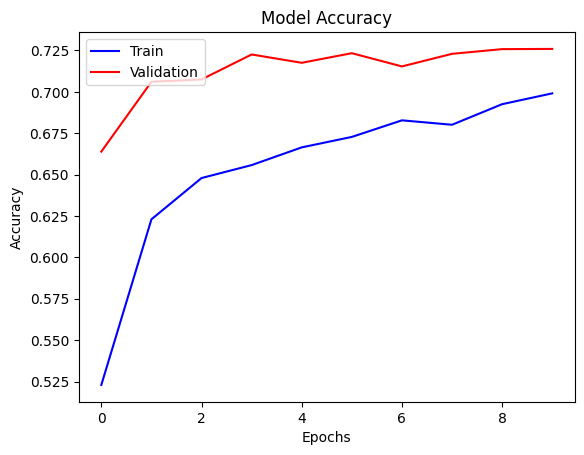

In [62]:
generate_graph(history_cnn_embeddings_a)

In [64]:
# let's do another try but with different batch size and more epochs, also add some small dropout after conv layers

class Model_CNN_embedding_B():
    
    def __init__(self, vocab_size, max_length):
        self.embedding_dim = 200  
        self.embeddings_index = load_glove_embeddings("C:/Users/kaczm/OneDrive/Dokumenty/glove.twitter.27B.200d.txt")
        self.embedding_matrix = create_embedding_matrix(tokenizer, self.embeddings_index, self.embedding_dim, vocab_size)
        self.model = self.build_model(vocab_size, max_length)

    def build_model(self, vocab_size, max_length):
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=max_length, weights=[self.embedding_matrix], trainable=False),
            Dropout(0.6),
            Conv1D(filters=128, kernel_size=5, activation='relu'),
            Dropout(0.1),
            BatchNormalization(),  # batch normalization after Conv layer
            MaxPooling1D(pool_size=4),
            Conv1D(filters=64, kernel_size=4, activation='relu'),
            Dropout(0.1),
            MaxPooling1D(pool_size=4),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')  
        ])

        return model
    
model_cnn_embeddings_B = Model_CNN_embedding_B(vocab_size, max_length)

model_cnn_embeddings_B.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn_embeddings_b = model_cnn_embeddings_B.model.fit(X_train_tokenized, y_train, epochs=20, batch_size=64, validation_data=(X_test_tokenized, y_test), class_weight=class_weight_dict)

# Evaluate
loss, accuracy = history_cnn_embeddings_b.model.evaluate(X_test_tokenized, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/20
364/364 [==============================] - 13s 34ms/step - loss: 0.9849 - accuracy: 0.5051 - val_loss: 0.8142 - val_accuracy: 0.6438
Epoch 2/20
364/364 [==============================] - 17s 48ms/step - loss: 0.8408 - accuracy: 0.6030 - val_loss: 0.7317 - val_accuracy: 0.6933
Epoch 3/20
364/364 [==============================] - 10s 27ms/step - loss: 0.8016 - accuracy: 0.6273 - val_loss: 0.7010 - val_accuracy: 0.7057
Epoch 4/20
364/364 [==============================] - 10s 27ms/step - loss: 0.7748 - accuracy: 0.6467 - val_loss: 0.6856 - val_accuracy: 0.7112
Epoch 5/20
364/364 [==============================] - 10s 27ms/step - loss: 0.7666 - accuracy: 0.6499 - val_loss: 0.6778 - val_accuracy: 0.7110
Epoch 6/20
364/364 [==============================] - 10s 27ms/step - loss: 0.7573 - accuracy: 0.6569 - val_loss: 0.6811 - val_accuracy: 0.7120
Epoch 7/20
364/364 [==============================] - 10s 27ms/step - loss: 0.7467 - accuracy: 0.6603 - val_loss: 0.6694 - val_accuracy:

In [65]:
y_pred = model_cnn_embeddings_B.model.predict(X_test_tokenized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate and print F1 score and classification report
calculate_f1(y_test, y_pred_classes, average_mode='weighted')

243/243 [==============================] - 1s 3ms/step
F1 Score (weighted average): 0.73
Detailed classification report:
              precision    recall  f1-score   support

     neutral       0.73      0.66      0.69      3151
    negative       0.66      0.76      0.71      2162
    positive       0.79      0.79      0.79      2441

    accuracy                           0.73      7754
   macro avg       0.73      0.73      0.73      7754
weighted avg       0.73      0.73      0.73      7754



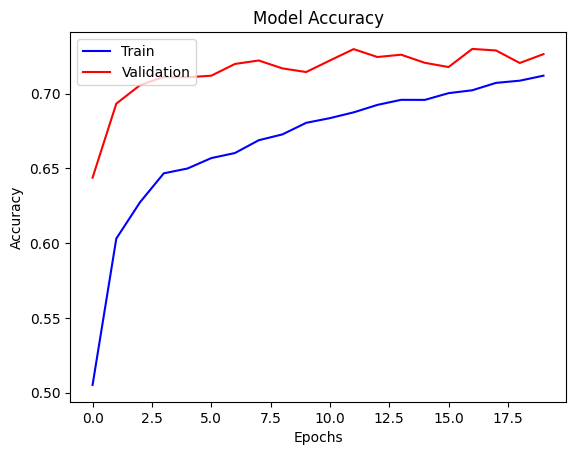

In [66]:
generate_graph(history_cnn_embeddings_b)

In [73]:
# let's do one last try with lesser dropout and higher batch size
from tensorflow.keras import regularizers

class Model_CNN_embedding_C():
    
    def __init__(self, vocab_size, max_length):
        self.embedding_dim = 200  
        self.embeddings_index = load_glove_embeddings("C:/Users/kaczm/OneDrive/Dokumenty/glove.twitter.27B.200d.txt")
        self.embedding_matrix = create_embedding_matrix(tokenizer, self.embeddings_index, self.embedding_dim, vocab_size)
        self.model = self.build_model(vocab_size, max_length)

    def build_model(self, vocab_size, max_length):
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=max_length, weights=[self.embedding_matrix], trainable=False),
            Dropout(0.4),
            Conv1D(filters=128, kernel_size=5, activation='relu'),
            BatchNormalization(), 
            Dropout(0.05),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=64, kernel_size=4, activation='relu'),
            BatchNormalization(), 
            Dropout(0.05),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=32, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
            Dense(3, activation='softmax')  
        ])


        return model
    
model_cnn_embeddings_C = Model_CNN_embedding_C(vocab_size, max_length)

model_cnn_embeddings_C.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn_embeddings_c = model_cnn_embeddings_C.model.fit(X_train_tokenized, y_train, epochs=10, batch_size=128, validation_data=(X_test_tokenized, y_test), class_weight=class_weight_dict)

# Evaluate
loss, accuracy = history_cnn_embeddings_c.model.evaluate(X_test_tokenized, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
182/182 [==============================] - 17s 85ms/step - loss: 1.0388 - accuracy: 0.4722 - val_loss: 0.9223 - val_accuracy: 0.5989
Epoch 2/10
182/182 [==============================] - 8s 41ms/step - loss: 0.8264 - accuracy: 0.6236 - val_loss: 0.7560 - val_accuracy: 0.6860
Epoch 3/10
182/182 [==============================] - 7s 41ms/step - loss: 0.7573 - accuracy: 0.6666 - val_loss: 0.7056 - val_accuracy: 0.7060
Epoch 4/10
182/182 [==============================] - 7s 40ms/step - loss: 0.7214 - accuracy: 0.6890 - val_loss: 0.7124 - val_accuracy: 0.6989
Epoch 5/10
182/182 [==============================] - 7s 41ms/step - loss: 0.6939 - accuracy: 0.6989 - val_loss: 0.6811 - val_accuracy: 0.7140
Epoch 6/10
182/182 [==============================] - 7s 40ms/step - loss: 0.6800 - accuracy: 0.7034 - val_loss: 0.6838 - val_accuracy: 0.7151
Epoch 7/10
182/182 [==============================] - 7s 40ms/step - loss: 0.6597 - accuracy: 0.7169 - val_loss: 0.6697 - val_accuracy: 0.720

In [74]:
y_pred = model_cnn_embeddings_C.model.predict(X_test_tokenized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate and print F1 score and classification report
calculate_f1(y_test, y_pred_classes, average_mode='weighted')

243/243 [==============================] - 1s 4ms/step
F1 Score (weighted average): 0.72
Detailed classification report:
              precision    recall  f1-score   support

     neutral       0.65      0.78      0.71      3151
    negative       0.72      0.66      0.69      2162
    positive       0.84      0.70      0.76      2441

    accuracy                           0.72      7754
   macro avg       0.74      0.71      0.72      7754
weighted avg       0.73      0.72      0.72      7754



In [85]:
# let's see how combvining model outputs will perform

def ensemble_predict(model1, model2, weights, input_data):
    proba_model1 = model1.model.predict(input_data)
    proba_model2 = model2.model.predict(input_data)
    
    # compute the weighted average of the predicted probabilities
    weighted_proba = np.zeros_like(proba_model1)
    for i, class_name in enumerate(['neutral', 'negative', 'positive']):
        weighted_proba[:, i] = (weights['model1'][i] * proba_model1[:, i] +
                                weights['model2'][i] * proba_model2[:, i])
    
    # redict the class with the highest weighted average probability
    predictions = np.argmax(weighted_proba, axis=1)
    
    return predictions

weights = {
    'model1': [0.3, 0.55, 0.4],  # [weight for neutral, weight for negative, weight for positive]
    'model2': [0.7, 0.45, 0.6]
}

predictions = ensemble_predict(model_cnn_embeddings_C, model_cnn_embeddings_B, weights, X_test_tokenized)

243/243 [==============================] - 1s 3ms/step


In [86]:
calculate_f1(y_test, predictions,average_mode='weighted')

F1 Score (weighted average): 0.73
Detailed classification report:
              precision    recall  f1-score   support

     neutral       0.70      0.72      0.71      3151
    negative       0.70      0.71      0.70      2162
    positive       0.81      0.77      0.79      2441

    accuracy                           0.73      7754
   macro avg       0.73      0.73      0.73      7754
weighted avg       0.73      0.73      0.73      7754



In [25]:
# set the padding token to the eos_token
import torch

tokenizer.pad_token = tokenizer.eos_token

texts_list = texts.tolist()

inputs = tokenizer.batch_encode_plus(
    texts_list, 
    padding=True, 
    truncation=True, 
    max_length=512  
)

input_ids = torch.tensor(inputs["input_ids"])
attention_mask = torch.tensor(inputs["attention_mask"])


In [ ]:
# last part is fine tuning a model from huggingface library

from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from torch.utils.data import Dataset, DataLoader

checkpoint = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# ensure the tokenizer uses the correct padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

X_train_distilbert, X_test_distilbert, y_train_distilbert, y_test_distilbert = train_test_split(input_ids, sentiments_array, test_size = 0.25, random_state = 42)

class CustomDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        item = {"input_ids": self.input_ids[idx], "labels": self.labels[idx]}
        return item

# create PyTorch datasets (assumed to be done already)
train_dataset = CustomDataset(X_train_distilbert, y_train_distilbert)
eval_dataset = CustomDataset(X_test_distilbert, y_test_distilbert)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

trainer.train()

In [ ]:
# Save the model to the specified directory
model.save_pretrained('C:/Users/kaczm/OneDrive/Pulpit/ZUM_pr_2')

# tokenizer as well in the same directory
tokenizer.save_pretrained('C:/Users/kaczm/OneDrive/Pulpit/ZUM_pr_2')

In [ ]:
from transformers import DistilBertForSequenceClassification, AutoTokenizer

# Load the model
model_path = 'C:/Users/kaczm/OneDrive/Pulpit/ZUM_pr_2'
model = DistilBertForSequenceClassification.from_pretrained(model_path)

tokenizer = AutoTokenizer.from_pretrained(model_path)


In [16]:
import torch

texts_to_predict = ["I love this!", "I don't know what to expect.", "That was the worst!"]

def predict_sentiment(model, tokenizer, sentence):
    inputs = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"  # Return PyTorch tensors
    )
    

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():  
        outputs = model(**inputs)
        predictions = outputs.logits

    probabilities = torch.nn.functional.softmax(predictions, dim=-1)

    # get the predicted class with the highest probability
    predicted_class_index = torch.argmax(probabilities, dim=1).item()  # Use .item() to extract the value

    sentiment_mapping = {0: "neutral", 1: "negative", 2: "positive"}

    # print the result
    predicted_sentiment = sentiment_mapping[predicted_class_index]
    print(f'The predicted sentiment is {predicted_sentiment}')
    
    return predicted_class_index

In [19]:
predict_sentiment(model, tokenizer, texts_to_predict[2])

The predicted sentiment is negative


1